In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
import datetime

plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Generate Series from a Linear Model

In [2]:
def generateLinearSeries(length=200,pro_noise=0.0,p=3, ns=False):
    E1 = np.exp(rand.random(p)*1j)
    E2 = np.exp(rand.random(p)*1j)
    
    # generate column vector basis of R^p, ensure non singular
    V1 = rand.random((p,p))
    V2 = rand.random((p,p))
    while abs(la.det(V1)) < 0.01 or abs(la.det(V2)) < 0.01:
        V1 = rand.random((p,p))
        V2 = rand.random((p,p))
        
    # V is our basis of eigenvectors which shift linearly from V1
    # to V2 over the course of the time series. The eigenvalues
    # also move similarly
    V = lambda t: V1 + t * (V2 - V1)
    E = lambda t: E1 + t * (E2 - E1)
    A = lambda t: V(t) @ np.identity(p) * E(t) @ la.inv(V(t))
    
    X = np.zeros((length,p),dtype=complex)
    X[0] = rand.normal(p)

    for i in range(length-1):
        t = i / (length-1) if ns else 0
        X[i+1] = (A(t) @ X[i]) + rand.normal(0,pro_noise,p)
    
    return standardize(X[:,0]) + np.linspace(0,2,num=length) if ns else X[:,0]

c:\users\kenneth gee\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\cbook\__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


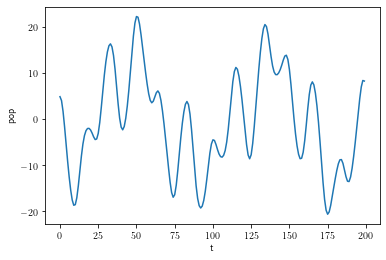

In [3]:
plotTS(generateLinearSeries(p=5, ns=False))

In [9]:
theta = lambda t: (1+t)*np.pi/2
A = lambda theta: np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

In [12]:
A(theta(0))

array([[ 6.123234e-17, -1.000000e+00],
       [ 1.000000e+00,  6.123234e-17]])

In [295]:
# Observation Noise versus Nonstationarity Rate
T = 200
o_n = 0.1
N_replicates = 100
E_max = 5

# ts_std is the standard deviation of the time series which
# is normalized to 1
log_std = 1

# nonstationarity status, delta, theta, r_sqrd
results = np.zeros((N_replicates * 2, 4))
results_index = 0

for NS in [True, False]:
    for i in range(N_replicates):
        Xr = standardize(generateLinearSeries(length=T, p=E_max, ns=NS))
        Xr += (rand.normal(0,1,T) * log_std * o_n)
        
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)

        results[results_index] = np.array([int(NS), delta_agg, theta_agg, r_sqrd])
        results_index += 1
        
np.savetxt(f"linear_obsnoise_vs_NS_Rate.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f")

# Mockup of delta vs theta graph

In [306]:
# fill with data of results for Hastings Powell and Logistic in Round 2
l_data = np.loadtxt("logistic_obsnoise_vs_NS_Rate.csv",delimiter=',')
hp_data = np.loadtxt("hastings_powell_obsnoise_vs_NS_Rate.csv",delimiter=',')
lin_data = np.loadtxt("linear_obsnoise_vs_NS_Rate.csv",delimiter=',')

l_nonstat = l_data[np.logical_and(l_data[:,0] == 0.1,l_data[:,1] == 2)][:,2:4]
l_stat = l_data[np.logical_and(l_data[:,0] == 0.1,l_data[:,1] == 0)][:,2:4]
hp_nonstat = hp_data[np.logical_and(hp_data[:,0] == 0.1,hp_data[:,1] == 2)][:,2:4]
hp_stat = hp_data[np.logical_and(hp_data[:,0] == 0.1,hp_data[:,1] == 0)][:,2:4]
lin_nonstat = lin_data[lin_data[:,0] == 1][:,1:3]
lin_stat = lin_data[lin_data[:,0] == 0][:,1:3]

In [309]:
lin_stat

array([[0.00000e+00, 0.00000e+00],
       [9.17000e-01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [4.35500e+00, 7.05400e-01],
       [0.00000e+00, 1.80000e-02],
       [0.00000e+00, 0.00000e+00],
       [3.66000e-01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [2.47580e+00, 0.00000e+00],
       [4.26040e+01, 0.00000e+00],
       [0.00000e+00, 2.49300e-01],
       [0.00000e+00, 3.60000e-02],
       [5.41530e+00, 1.05900e-01],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.58000e-02],
       [0.00000e+00, 1.47400e-01],
       [3.25000e-02, 1.65900e+00],
       [0.00000e+00, 1.37500e-01],
       [1.07962e+01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [2.24615e+01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00],
       [0.00000e+00,

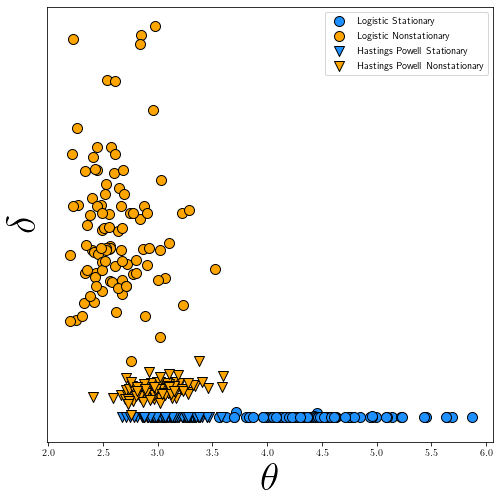

In [330]:
# we assume T=200, obs=0.2, no process noise.

size = 100

dvt_fig, dvt_ax = plt.subplots(1, figsize=(8,8))
dvt_ax.set_xlabel(r"$\theta$",fontsize=40)
dvt_ax.set_ylabel(r"$\delta$",fontsize=40)
# dvt_ax.set_xticks([])
dvt_ax.set_yticks([])

dvt_ax.scatter(l_stat[:,1], l_stat[:,0], c="dodgerblue", s=size, edgecolors="black", label="Logistic Stationary")
dvt_ax.scatter(l_nonstat[:,1], l_nonstat[:,0], c="orange", s=size, edgecolors="black", label="Logistic Nonstationary")
dvt_ax.scatter(hp_stat[:,1], hp_stat[:,0], c="dodgerblue",marker="v", s=size, edgecolors="black", label="Hastings Powell Stationary")
dvt_ax.scatter(hp_nonstat[:,1], hp_nonstat[:,0], c="orange",marker="v", s=size, edgecolors="black", label="Hastings Powell Nonstationary")
#dvt_ax.scatter(lin_stat[:,1], lin_stat[:,0], c="dodgerblue",marker=">", s=size, edgecolors="black", label="Linear Stationary")
#dvt_ax.scatter(lin_nonstat[:,1], lin_nonstat[:,0], c="orange",marker=">", s=size, edgecolors="black", label="Linear Nonstationary")

plt.legend()
plt.show()

# Old Code

In [ ]:
def rand_disc(n, minimum=0,maximum=1):
    return np.sign(rand.uniform(-1,1,size=n))*rand.uniform(minimum,maximum,size=n)
    # return np.exp(rand.uniform(size=n)*np.pi*2j)
    # return rand.uniform(minimum,maximum,size=n)*np.exp(rand.uniform(size=n)*np.pi*2j)

def calculate_coeff(roots):
    
    # contains the phi which satisfies (1-phi*z)=0 when z=root
    coefs_root_form = -1 / roots
    subset_sizes = range(1,len(coefs_root_form)+1)
    
    # sum all 1 element subsets, then 2 element subsets, ... n element subsets
    return np.array([np.sum(np.prod(np.array(list(itertools.combinations(coefs_root_form, subset_size))),axis=1)) for subset_size in subset_sizes])
    
def eval_poly(coefs, value):
    return 1 + np.sum(coefs * (value ** np.arange(1,len(coefs)+1)))

In [ ]:
np.set_printoptions(suppress=True, precision=3)

roots = rand_disc(10,2,3)
coefs = calculate_coeff(roots)

print(np.array(list([eval_poly(coefs,root) for root in roots])))

In [ ]:
tlen = 100
X = rand_disc(tlen)
l = 6

ar_roots = rand_disc(l,np.pi,4)
ar_coeffs = -calculate_coeff(ar_roots)

for i in range(tlen-l):
    X[i+l] = np.sum(ar_coeffs * X[i:i+l])
    
plotTS(X)
ar_roots